In [5]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from factor_analyzer import FactorAnalyzer
import numpy as np
import matplotlib.pyplot as plt

# Load dataset
df = pd.read_csv("merged_data/final_merged.csv")

# Transform genres column into binary columns
unique_genres = set(genre for sublist in df["genres"].str.split() for genre in sublist)
for genre in unique_genres:
    df[genre] = df["genres"].apply(lambda x: 1 if genre in x.split() else 0)
df = df.drop(columns=["genres"])

# Select necessary columns for EFA and prediction
selected_columns = [
    "month",
    "year",
    "mpaa",
    "budget",
    "runtime",
    "screens",
    "opening_week",
    "domestic_box_office",
    "user_vote",
    "ratings",
    "critic_vote",
    "meta_score",
    "sequel",
    "country",
] + list(unique_genres)
df = df[selected_columns]

# Drop rows with NaN values
df.dropna(inplace=True)

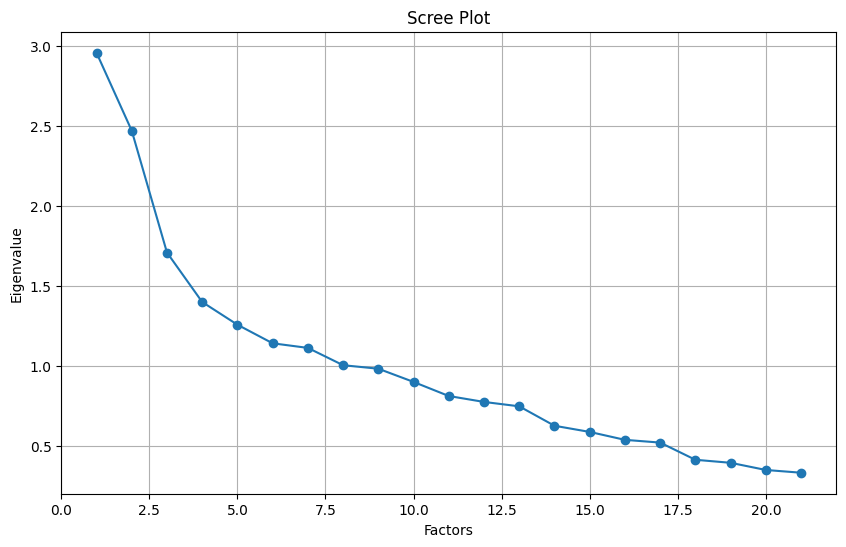

Number of factors to retain: 8
              Factor1   Factor2   Factor3   Factor4   Factor5   Factor6  \
War         -0.041490  0.011382 -0.039003  0.421570 -0.042187  0.061160   
Sport       -0.023874 -0.032462 -0.074941 -0.043167 -0.032006 -0.012731   
Romance     -0.071319 -0.365934 -0.297925 -0.057683 -0.266646 -0.009102   
Fantasy      0.501740  0.148706  0.012674 -0.048457 -0.160494 -0.006195   
Animation    0.714899  0.051708 -0.020719 -0.006802  0.035112 -0.099762   
Mystery     -0.029769 -0.063628  0.495848 -0.061682  0.137247  0.119351   
Sci-Fi       0.058378  0.482891  0.060018 -0.077794 -0.133217  0.049228   
Drama       -0.138405 -0.426455 -0.153249  0.262595  0.026817  0.446906   
Action      -0.082761  0.783854 -0.119568  0.051046  0.201385  0.068050   
Biography   -0.091058 -0.140909 -0.060755  0.333663  0.008182  0.128705   
Musicalal    0.280300 -0.090223 -0.035695 -0.008121 -0.010314 -0.004769   
Adventure    0.571991  0.496908 -0.128990 -0.001361 -0.112690  0.0199

In [6]:
# Separate the genre columns
genre_columns = list(unique_genres)
genre_data = df[genre_columns]
scaler = StandardScaler()
genre_data_scaled = scaler.fit_transform(genre_data)

# Determine the number of factors to retain
fa = FactorAnalyzer()
fa.fit(genre_data_scaled)

# Get eigenvalues
eigenvalues, _ = fa.get_eigenvalues()

# Plot eigenvalues (scree plot)
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues) + 1), eigenvalues, marker="o")
plt.title("Scree Plot")
plt.xlabel("Factors")
plt.ylabel("Eigenvalue")
plt.grid()
plt.show()

# Retain factors with eigenvalues > 1
n_factors = sum(eigenvalues > 1)
print(f"Number of factors to retain: {n_factors}")

# Perform EFA with the determined number of factors
fa = FactorAnalyzer(n_factors=n_factors, rotation="varimax")
fa.fit(genre_data_scaled)
loadings = fa.loadings_

# Create a DataFrame for loadings to interpret factors
loadings_df = pd.DataFrame(
    loadings, index=genre_columns, columns=[f"Factor{i+1}" for i in range(n_factors)]
)
print(loadings_df)
print("\nSignificant Loadings (absolute value > 0.3):")
print(loadings_df[loadings_df.abs() > 0.3].dropna(how="all"))

In [7]:
# Transform the original genre data into factor scores
from sklearn.model_selection import GridSearchCV, cross_val_score


factor_scores = fa.transform(genre_data_scaled)
factor_scores_df = pd.DataFrame(
    factor_scores, columns=[f"Factor{i+1}" for i in range(n_factors)]
)

# Combine factor scores with the original dataframe
df = pd.concat([df, factor_scores_df], axis=1)

# Drop the original genre columns
df = df.drop(columns=genre_columns)
mpaa_label_encoder = LabelEncoder()
country_label_encoder = LabelEncoder()
df["mpaa"] = mpaa_label_encoder.fit_transform(df["mpaa"])
df["country"] = country_label_encoder.fit_transform(df["country"])
# Separate features and target
X = df.drop("domestic_box_office", axis=1)
y = df["domestic_box_office"]
y_log = np.log(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_log, test_size=0.2, random_state=42
)

# Preprocessing pipeline for numerical features
numeric_features = [
    "month",
    "year",
    "budget",
    "runtime",
    "screens",
    "opening_week",
    "user_vote",
    "ratings",
    "critic_vote",
    "meta_score",
] + [f"Factor{i+1}" for i in range(n_factors)]
numeric_transformer = StandardScaler()


preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("regressor", RandomForestRegressor(random_state=42)),
    ]
)

param_grid = {
    "regressor__n_estimators": [50, 100, 150],
    "regressor__max_depth": [None, 10, 20, 30],
    "regressor__min_samples_split": [2, 5, 10],
}

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, n_jobs=-1, scoring="neg_mean_squared_error"
)
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
print(f"Best score: {grid_search.best_score_}")

best_model = grid_search.best_estimator_
y_pred_log = best_model.predict(X_test)

y_pred = np.expm1(y_pred_log)
y_test_actual = np.expm1(y_test)

mse = mean_squared_error(y_test_actual, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, y_pred)
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R^2 Score: {r2}")

scores = cross_val_score(best_model, X, y, cv=5, scoring="neg_mean_squared_error")
rmse_scores = np.sqrt(-scores)

print(f"Cross-validated RMSE scores: {rmse_scores}")
print(f"Mean RMSE: {rmse_scores.mean()}")
print(f"Standard deviation of RMSE: {rmse_scores.std()}")

Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 100}
Best score: -0.16487505702333982
Mean Squared Error (MSE): 710282761145741.6
Root Mean Squared Error (RMSE): 26651130.579128187
R^2 Score: 0.8949078814765489
Cross-validated RMSE scores: [32258906.71651364 29227856.19856626 20888544.86251683 25598875.29299153
 24006015.07474761]
Mean RMSE: 26396039.629067175
Standard deviation of RMSE: 3976746.9751266153


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

columns = [
    "month",
    "year",
    "budget",
    "runtime",
    "screens",
    "opening_week",
    "user_vote",
    "ratings",
    "critic_vote",
    "domestic_box_office",
    "meta_score",
    "sequel",
] + [f"Factor{i+1}" for i in range(n_factors)]
correlation_matrix = df[columns].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Correlation Matrix")
plt.show()

In [9]:
# Example new movie data
new_movie = {
    "month": 5.0,
    "year": 2017.0,
    "mpaa": "PG-13",
    "budget": 5300000.0,
    "runtime": 89.0,
    "screens": 2270.0,
    "opening_week": 11205562.0,
    "country": "United States",
    "user_vote": 61000.0,
    "ratings": 5.6,
    "critic_vote": 103.0,
    "meta_score": 5.0,
}

# Convert mpaa and country using LabelEncoder
new_movie["mpaa"] = mpaa_label_encoder.transform([new_movie["mpaa"]])[0]
new_movie["country"] = country_label_encoder.transform([new_movie["country"]])[0]

# Calculate factor scores for the new movie
# Assuming genre_data for the new movie is available as a binary vector
new_movie_genres = np.array(
    [1 if genre in ["Horror","Mystery", "Thriller"] else 0 for genre in unique_genres]
).reshape(
    1, -1
)  # Example genres
new_movie_genres_scaled = scaler.transform(new_movie_genres)
new_movie_factors = fa.transform(new_movie_genres_scaled)

# Combine new movie data with factor scores
new_movie.update({f"Factor{i+1}": new_movie_factors[0, i] for i in range(n_factors)})

# Create DataFrame
new_movie_df = pd.DataFrame([new_movie])

print(new_movie_df)

# Predict the revenue
predicted_revenue = best_model.predict(new_movie_df)
print(f"Predicted revenue: {np.expm1(predicted_revenue[0])}")
print("------------------------------------")

   month    year  mpaa     budget  runtime  screens  opening_week  country  \
0    5.0  2017.0     3  5300000.0     89.0   2270.0    11205562.0      192   

   user_vote  ratings  critic_vote  meta_score  Factor1   Factor2  Factor3  \
0    61000.0      5.6        103.0         5.0 -0.35694 -0.167073  2.69688   

    Factor4   Factor5   Factor6   Factor7   Factor8  
0 -0.397604 -0.344263 -0.063831 -0.309649 -0.098577  
Predicted revenue: 31944426.675761484
------------------------------------


d:\Code\crawl\2023.2-Data-Science\myenv\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
